In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import zipfile

#unzip dataset
local_zip = './dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./dataset')
zip_ref.close()

In [6]:
#IGNORE THIS PART: i cant figure out why this doesnt work
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", required=True, #The path to the input dataset of faces and and faces with masks
	help="path to input dataset")
ap.add_argument("-p", "--plot", type=str, default="plot.png", #The path to your output training history plot, which will be generated using matplotlib
	help="path to output loss/accuracy plot")
ap.add_argument("-m", "--model", type=str, #The path to the resulting serialized face mask classification model
	default="mask_detector.model",
	help="path to output face mask detector model")
args = vars(ap.parse_args())

usage: ipykernel_launcher.py [-h] [-d DATASET] [-p PLOT] [-m MODEL]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-3825be3a-df7c-4734-afc2-b23bc594f674.json


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [8]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [7]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
#imagePaths = list(paths.list_images(args["dataset"]))
imagePaths = list(paths.list_images('./dataset'))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] loading images...


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [9]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [10]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
#Load MobileNet with pre-trained ImageNet weights, leaving off head of network
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
#Construct a new FC head, and append it to the base in place of the old head
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
#Freeze the base layers of the network (Lines 106 and 107). The weights of these base layers will not be updated during the process of backpropagation, whereas the head layer weights will be tuned.
for layer in baseModel.layers:
	layer.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [16]:
#callback
import tensorflow.keras.callbacks as Callback
class myCallback(Callback.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.999:
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

# compile our model
print("[INFO] compiling model...")
#uses LR decay that incrementally changes learning rate
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network
#// is floor division
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
  epochs=EPOCHS,
	callbacks=[callbacks])

[INFO] compiling model...
[INFO] training head...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
101/101 [==============================] - 151s 1s/step - loss: 0.0636 - accuracy: 0.9820 - val_loss: 0.0575 - val_accuracy: 0.9816
Epoch 2/20
101/101 [==============================] - 147s 1s/step - loss: 0.0629 - accuracy: 0.9820 - val_loss: 0.0613 - val_accuracy: 0.9803
Epoch 3/20
101/101 [==============================] - 145s 1s/step - loss: 0.0503 - accuracy: 0.9854 - val_loss: 0.0497 - val_accuracy: 0.9828
Epoch 4/20
101/101 [==============================] - 144s 1s/step - loss: 0.0452 - accuracy: 0.9879 - val_loss: 0.0427 - val_accuracy: 0.9828
Epoch 5/20
101/101 [==============================] - 144s 1s/step - loss: 0.0501 - accuracy: 0.9836 - val_loss: 0.0388 - val_accuracy: 0.9828
Epoch 6/20
101/101 [==============================] - 144s 1s/step - loss: 0.0392 - accuracy: 0.9873 - val_loss: 0.0378 - val_accuracy: 0.9865
Epoch 7/20
101/101 [==============================] - 142s 1s/step - loss: 0.0410 - accuracy: 0.9876 - val_loss: 0.0380 - val_accuracy: 0.9853

In [19]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save('mask_detector', save_format="h5")
#model.save(args["model"], save_format="h5")

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.98      1.00      0.99       428
without_mask       1.00      0.98      0.99       386

    accuracy                           0.99       814
   macro avg       0.99      0.99      0.99       814
weighted avg       0.99      0.99      0.99       814

[INFO] saving mask detector model...


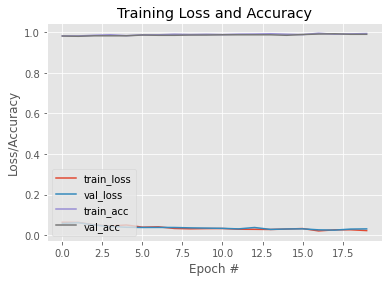

In [20]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
#plt.savefig(args["plot"])